In [109]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
import argparse
import sys
import numpy as np
import glob
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
import pandas as pd

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset

from CustomDatasets import MagnetDataset
from Unet_MaxProkop import UNet
from Trainer import Trainer


In [111]:

train_set = MagnetDataset("../../Stage_magnet", (0,0.60),maximum_elements=8)
val_set = MagnetDataset("../../Stage_magnet", (0.60,0.80),maximum_elements=8)

train_loader = DataLoader(train_set,batch_size=8)
val_loader = DataLoader(val_set,batch_size=8)

print(train_set[0][0].shape)
print(train_set[0][1].shape)


(4, 120, 80)
(2, 120, 80)


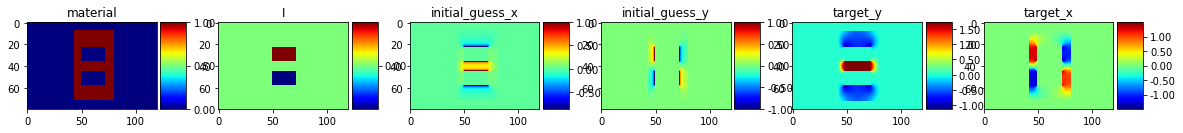

In [112]:
idx = 2
sample=val_set[idx]

fig, axes = plt.subplots(1,6,figsize=(20,4))

for i, name, image in zip(range(6),["material","I","initial_guess_x","initial_guess_y","target_y","target_x"], [sample[0][0,:,:],sample[0][1,:,:],sample[0][2,:,:],sample[0][3,:,:],sample[1][0,:,:],sample[1][1,:,:]]):
    im = axes[i].imshow(image.T, cmap='jet',interpolation='none')
    axes[i].set_title(name)

    divider = make_axes_locatable(axes[i])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax, ticks=MultipleLocator(0.5), format="%.2f")
    

First takeaway: improve initial guess

Split up initial guess into x and y component

In [113]:
#Create model
model = UNet(in_channels=4,out_channels=2,depth=2)

In [116]:
# Select device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.has_mps:
    device = 'mps'
else:
    device = 'cpu'

print(device)

mps


In [117]:
#Create Trainer

trainer_parameters = {
    "optimizer": optim.Adam,
    "optimizer_parameters": {
        "lr":5e-4
    },
    "loss_fun":nn.MSELoss,
    "device":torch.device(device),
    "model":model,
    "train_dataloader":train_loader,
    "val_dataloader":val_loader,
    "num_epochs": 400,
    "priority_mask_mode":"material"
}

trainer = Trainer(**trainer_parameters)

In [118]:
train_hist,val_hist = trainer.train()

/Users/fstummer/projects/personal/github/MaxAndFlorian/Unet/functions.py:73: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_b = np.arctan(dy_b/dx)
/Users/fstummer/projects/personal/github/MaxAndFlorian/Unet/functions.py:77: RuntimeWarning: divide by zero encountered in double_scalars
  denominator_a = np.sqrt(dx**2+dy_a**2)
/Users/fstummer/projects/personal/github/MaxAndFlorian/Unet/functions.py:73: RuntimeWarning: invalid value encountered in double_scalars
  alpha_b = np.arctan(dy_b/dx)
/Users/fstummer/projects/personal/github/MaxAndFlorian/Unet/functions.py:77: RuntimeWarning: invalid value encountered in double_scalars
  denominator_a = np.sqrt(dx**2+dy_a**2)


	 Epoch 1:	 Train_loss: 0.1091	 Val_loss: 0.1017	11:16:36:41
	 Epoch 2:	 Train_loss: 0.1058	 Val_loss: 0.0991	11:16:36:48
	 Epoch 3:	 Train_loss: 0.1032	 Val_loss: 0.0967	11:16:36:56
	 Epoch 4:	 Train_loss: 0.1010	 Val_loss: 0.0946	11:16:37:4
	 Epoch 5:	 Train_loss: 0.0991	 Val_loss: 0.0916	11:16:37:11
	 Epoch 6:	 Train_loss: 0.0963	 Val_loss: 0.0887	11:16:37:19
	 Epoch 7:	 Train_loss: 0.0937	 Val_loss: 0.0863	11:16:37:26
	 Epoch 8:	 Train_loss: 0.0913	 Val_loss: 0.0835	11:16:37:34
	 Epoch 9:	 Train_loss: 0.0888	 Val_loss: 0.0799	11:16:37:41
	 Epoch 10:	 Train_loss: 0.0856	 Val_loss: 0.0764	11:16:37:49
	 Epoch 11:	 Train_loss: 0.0824	 Val_loss: 0.0731	11:16:37:56
	 Epoch 12:	 Train_loss: 0.0792	 Val_loss: 0.0692	11:16:38:4
	 Epoch 13:	 Train_loss: 0.0756	 Val_loss: 0.0665	11:16:38:11
	 Epoch 14:	 Train_loss: 0.0725	 Val_loss: 0.0641	11:16:38:19
	 Epoch 15:	 Train_loss: 0.0700	 Val_loss: 0.0647	11:16:38:26
	 Epoch 16:	 Train_loss: 0.0692	 Val_loss: 0.0630	11:16:38:35
	 Epoch 17:	 Train_

/Users/fstummer/projects/personal/github/MaxAndFlorian/Unet/functions.py:73: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_b = np.arctan(dy_b/dx)
/Users/fstummer/projects/personal/github/MaxAndFlorian/Unet/functions.py:77: RuntimeWarning: divide by zero encountered in double_scalars
  denominator_a = np.sqrt(dx**2+dy_a**2)
/Users/fstummer/projects/personal/github/MaxAndFlorian/Unet/functions.py:73: RuntimeWarning: invalid value encountered in double_scalars
  alpha_b = np.arctan(dy_b/dx)
/Users/fstummer/projects/personal/github/MaxAndFlorian/Unet/functions.py:77: RuntimeWarning: invalid value encountered in double_scalars
  denominator_a = np.sqrt(dx**2+dy_a**2)


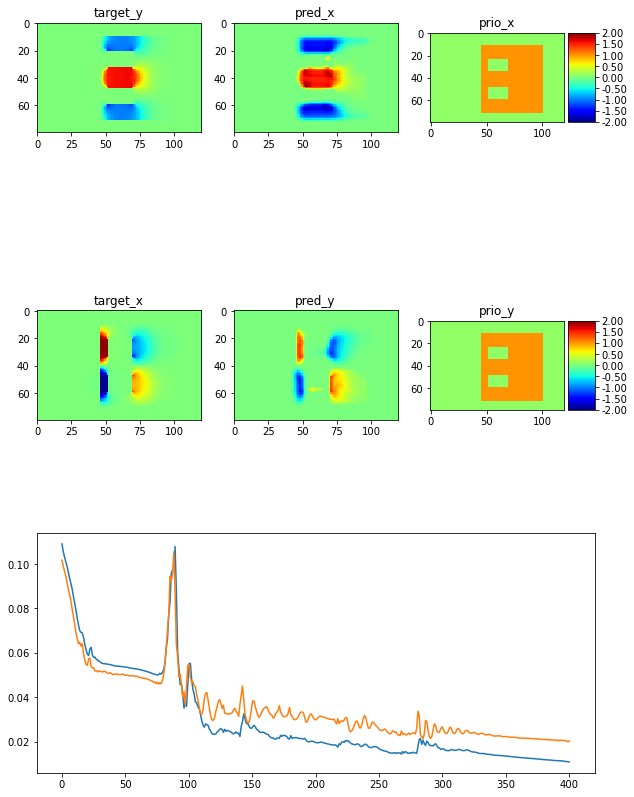

In [121]:
idx = 132
x,y=train_set[idx]

#x[1,:,:] = np.zeros_like(sample[0][1,:,:])

fig, axes = plt.subplots(3,3,figsize=(10,15))

gs = axes[2, 0].get_gridspec()
axes[2,0].remove()
axes[2,1].remove()
axes[2,2].remove()
axbig = fig.add_subplot(gs[2, 0:])

im0 = axes[0][0].imshow(y[0,:,:].T,vmin=-2, vmax=2, cmap='jet',interpolation='none')
axes[0][0].set_title("target_y")
im1 = axes[1][0].imshow(y[1,:,:].T,vmin=-2, vmax=2, cmap='jet',interpolation='none')
axes[1][0].set_title("target_x")

model.to('cpu')
prediction = model(torch.tensor(x).unsqueeze(0).float()).squeeze().detach().numpy() 

im2 = axes[0][1].imshow(prediction[0,:,:].T,vmin=-2, vmax=2, cmap='jet',interpolation='none')
axes[0][1].set_title("pred_x")
im3 = axes[1][1].imshow(prediction[1,:,:].T,vmin=-2, vmax=2, cmap='jet',interpolation='none')
axes[1][1].set_title("pred_y")

material_stack = torch.stack([torch.tensor(x)[0,:,:],torch.tensor(x)[0,:,:]],0)
priority_mask = torch.max(torch.ones_like(torch.tensor(y))*0.1,material_stack)


im2 = axes[0][2].imshow(priority_mask[0,:,:].T,vmin=-2, vmax=2, cmap='jet',interpolation='none')
axes[0][2].set_title("prio_x")
im3 = axes[1][2].imshow(priority_mask[1,:,:].T,vmin=-2, vmax=2, cmap='jet',interpolation='none')
axes[1][2].set_title("prio_y")

divider = make_axes_locatable(axes[0][2])
cax = divider.append_axes("right", size="20%", pad=0.05)
cbar = plt.colorbar(im1, cax=cax, ticks=MultipleLocator(0.5), format="%.2f")

divider = make_axes_locatable(axes[1][2])
cax = divider.append_axes("right", size="20%", pad=0.05)
cbar = plt.colorbar(im3, cax=cax, ticks=MultipleLocator(0.5), format="%.2f")


x = np.linspace(0, trainer_parameters["num_epochs"], trainer_parameters["num_epochs"])
axbig.plot(x, train_hist)
axbig.plot(x, val_hist)


